# Imports

In [13]:
import numpy as np
import numpy.random as rn
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from tqdm import tqdm
%matplotlib inline

# Helpers

## Gridworld (Global)

**Source: rl_helper.ipynb available on the BruinLearn**

In [62]:
## Define the gridworld MDP class

class Gridworld(object):
    """
    Gridworld MDP.
    """

    def __init__(self, grid_size, wind, discount):
        """
        grid_size: Grid size. int.
        wind: Chance of moving randomly. float.
        discount: MDP discount. float.
        -> Gridworld
        """

        self.actions = ((1, 0), (0, 1), (-1, 0), (0, -1))
        self.n_actions = len(self.actions)
        self.n_states = grid_size**2
        self.grid_size = grid_size
        self.wind = wind
        self.discount = discount

        # Preconstruct the transition probability array.
        self.transition_probability = np.array(
            [[[self._transition_probability(i, j, k)
               for k in range(self.n_states)]
              for j in range(self.n_actions)]
             for i in range(self.n_states)])

    def __str__(self):
        return "Gridworld({}, {}, {})".format(self.grid_size, self.wind,
                                              self.discount)

    def int_to_point(self, i):
        """
        Convert a state int into the corresponding coordinate.

        i: State int.
        -> (x, y) int tuple.
        """

        return (i % self.grid_size, i // self.grid_size)

    def point_to_int(self, p):
        """
        Convert a coordinate into the corresponding state int.

        p: (x, y) tuple.
        -> State int.
        """

        return int(p[0] + p[1]*self.grid_size)

    def neighbouring(self, i, k):
        """
        Get whether two points neighbour each other. Also returns true if they
        are the same point.

        i: (x, y) int tuple.
        k: (x, y) int tuple.
        -> bool.
        """

        return abs(i[0] - k[0]) + abs(i[1] - k[1]) <= 1

    def _transition_probability(self, i, j, k):
        """
        Get the probability of transitioning from state i to state k given
        action j.

        i: State int.
        j: Action int.
        k: State int.
        -> p(s_k | s_i, a_j)
        """

        xi, yi = self.int_to_point(i)
        xj, yj = self.actions[j]
        xk, yk = self.int_to_point(k)


        if not self.neighbouring((xi, yi), (xk, yk)):
            return 0

        # Is k the intended state to move to?
        if (xi + xj, yi + yj) == (xk, yk):
            return 1 - 0.75 * self.wind

        # If these are not the same point, then we can move there by wind.
        if (xi, yi) != (xk, yk):
            return self.wind / 4


        # If these are the same point, we can only move here by either moving
        # off the grid or being blown off the grid. Are we on a corner or not?
        if i in [0, self.grid_size-1, self.grid_size*10, self.grid_size**2-1]:
            # Corner.
            # Can move off the edge in two directions.
            # Did we intend to move off the grid?
            if min(xi+xj, yi+yj) < 0 or max(xi+xj, yi+yj) >= self.grid_size:
                # we have the regular success chance of staying here
                # plus an extra chance of blowing onto the *other* off-grid square
                return 1 - 0.5 * self.wind
            else:
                # We can blow off the grid in either direction only by wind.
                return 0.5 * self.wind
        else:
            # Not a corner. Is it an edge?
            if 0 < xi < self.grid_size-1 and 0 < yi < self.grid_size-1:
                return 0

            else:#it is an edge
                # we Can only move off the edge in one direction.
                # Did we intend to move off the grid?
                if min(xi+xj, yi+yj) < 0 or max(xi+xj, yi+yj) >= self.grid_size:
                    #we have the regular success chance of staying here.
                    return 1 - 0.75 * self.wind
                else:
                    # We can blow off the grid only by wind.
                    return self.wind / 4

    def reward(self, state_int, reward_type):
        """
        Reward for being in state state_int.

        state_int: State integer. int.
        -> Reward.
        """
        #reward 1: fig 6
        reward1 = np.zeros((10,10), dtype=int)
        reward1[2, 5]=-10
        reward1[2, 6]=-10
        reward1[3, 5]=-10
        reward1[3, 6]=-10

        reward1[4, 1]=-10
        reward1[4, 2]=-10
        reward1[5, 1]=-10
        reward1[5, 2]=-10

        reward1[8, 2]=-10
        reward1[8, 3]=-10
        reward1[9, 2]=-10
        reward1[9, 3]=-10

        reward1[9,9]=1

        #reward 2: fig 7
        reward2 = np.zeros((10,10), dtype=int)

        reward2[1, 4] = -100
        reward2[1, 5] = -100
        reward2[1, 6] = -100

        reward2[2, 4] = -100
        reward2[2, 6] = -100
        reward2[3, 4] = -100
        reward2[3, 6] = -100
        reward2[4, 4] = -100
        reward2[5, 4] = -100
        reward2[6, 4] = -100

        reward2[3, 7] = -100
        reward2[3, 8] = -100
        reward2[4, 8] = -100
        reward2[5, 8] = -100
        reward2[6, 8] = -100

        reward2[7, 6] = -100
        reward2[7, 7] = -100
        reward2[7, 8] = -100

        reward2[8, 6] = -100

        reward2[9, 9] = 10

        xi, yi = self.int_to_point(state_int)

        if reward_type == 1:
            return reward1[xi,yi]
        elif reward_type == 2:
            return reward2[xi,yi]

#########################

## Plot Utils

In [63]:
## Function for plotting the matrix values
def plot_matrix(matrix, float_format='{:.1f}', title=None):
    fig, ax = plt.subplots()
    num_rows = len(matrix)
    min_val, max_val = 0, num_rows

    for i in range(num_rows):
        for j in range(num_rows):
            c = matrix[i][j]
            ax.text(j + 0.5, i + 0.5, float_format.format(c), va='center', ha='center')

    ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val, min_val)
    ax.set_xticks(np.arange(max_val))
    ax.set_yticks(np.arange(max_val))
    ax.xaxis.tick_top()
    ax.grid()
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()

In [64]:
## Creating the gridworld MDP with the following parameters

grid_size = 10
wind = 0.1
discount = 0.8

# Make the gridworld and associated data.
gw = Gridworld(grid_size, wind, discount)

# Question 1

In [74]:
## Plotting the reward value for each state of the grid, source: BruinLearn

def reward_grid_plot(reward_type):
    reward_matrix = np.zeros((grid_size, grid_size))
    for j in range(grid_size):
        for i in range(grid_size):
            reward_matrix[i][j] = gw.reward(gw.point_to_int((i,j)), reward_type)
    plot_matrix(reward_matrix)
    return reward_matrix

def heat_map_plot(matrix, title, float_format='{:.1f}'):
    plt.pcolor(np.flipud(matrix))
    for i in range(matrix.shape[0]):
      for j in range(matrix.shape[1]):
          plt.text(0.5+j, 9.5-i, float_format.format(matrix[i, j]),
                  ha='center', va='center', color='w')
    plt.colorbar()
    plt.axis('off')
    plt.title(title)
    plt.show()

## Reward 1

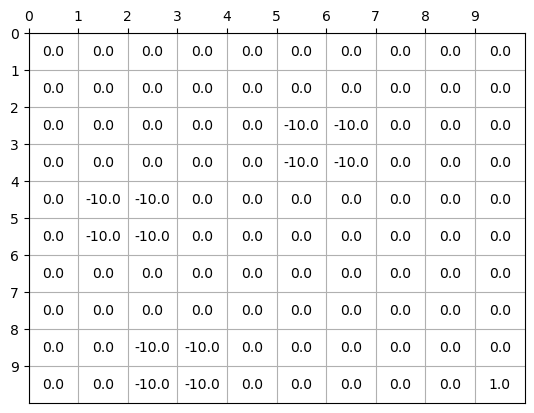

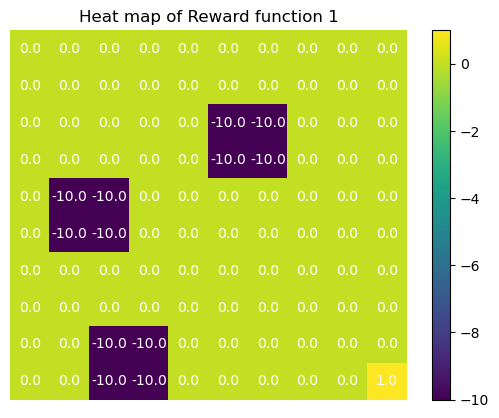

In [75]:
reward_matrix_1 = reward_grid_plot(reward_type=1)
heat_map_plot(reward_matrix_1, title=f'Heat map of Reward function 1')

## Reward 2

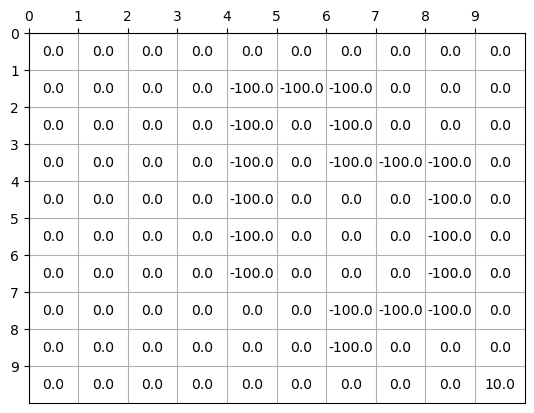

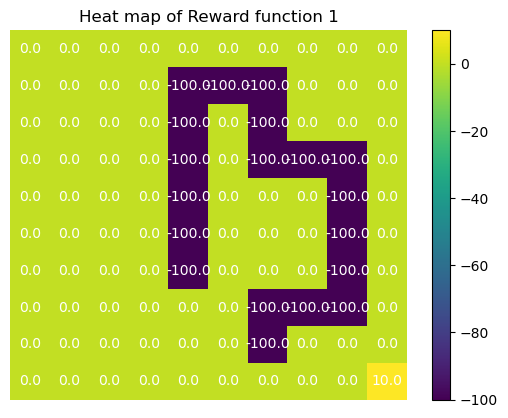

In [76]:
reward_matrix_2 = reward_grid_plot(reward_type=2)
heat_map_plot(reward_matrix_2, title=f'Heat map of Reward function 1')

## Report

The figures above shoes the heatmap with the reward values in each state in addition to the figures related to the reward values. 

# Question 2 and 3

## Environement

Added some new functions to the Gridworld class:

In [68]:

class Gridworld(object):
    """
    Gridworld MDP.
    """

    def __init__(self, grid_size, wind, discount):
        """
        grid_size: Grid size. int.
        wind: Chance of moving randomly. float.
        discount: MDP discount. float.
        -> Gridworld
        """

        self.actions = ((1, 0), (0, 1), (-1, 0), (0, -1))
        self.n_actions = len(self.actions)
        self.n_states = grid_size**2
        self.grid_size = grid_size
        self.wind = wind
        self.discount = discount

        # Preconstruct the transition probability array.
        self.transition_probability = np.array(
            [[[self._transition_probability(i, j, k)
               for k in range(self.n_states)]
              for j in range(self.n_actions)]
             for i in range(self.n_states)])

    def __str__(self):
        return "Gridworld({}, {}, {})".format(self.grid_size, self.wind,
                                              self.discount)

    def int_to_point(self, i):
        """
        Convert a state int into the corresponding coordinate.

        i: State int.
        -> (x, y) int tuple.
        """

        return (i % self.grid_size, i // self.grid_size)

    def point_to_int(self, p):
        """
        Convert a coordinate into the corresponding state int.

        p: (x, y) tuple.
        -> State int.
        """

        return int(p[0] + p[1]*self.grid_size)

    def neighbouring(self, i, k):
        """
        Get whether two points neighbour each other. Also returns true if they
        are the same point.

        i: (x, y) int tuple.
        k: (x, y) int tuple.
        -> bool.
        """

        return abs(i[0] - k[0]) + abs(i[1] - k[1]) <= 1

    def _transition_probability(self, i, j, k):
        """
        Get the probability of transitioning from state i to state k given
        action j.

        i: State int.
        j: Action int.
        k: State int.
        -> p(s_k | s_i, a_j)
        """

        xi, yi = self.int_to_point(i)
        xj, yj = self.actions[j]
        xk, yk = self.int_to_point(k)


        if not self.neighbouring((xi, yi), (xk, yk)):
            return 0

        # Is k the intended state to move to?
        if (xi + xj, yi + yj) == (xk, yk):
            return 1 - 0.75 * self.wind

        # If these are not the same point, then we can move there by wind.
        if (xi, yi) != (xk, yk):
            return self.wind / 4


        # If these are the same point, we can only move here by either moving
        # off the grid or being blown off the grid. Are we on a corner or not?
        if i in [0, self.grid_size-1, self.grid_size*10, self.grid_size**2-1]:
            # Corner.
            # Can move off the edge in two directions.
            # Did we intend to move off the grid?
            if min(xi+xj, yi+yj) < 0 or max(xi+xj, yi+yj) >= self.grid_size:
                # we have the regular success chance of staying here
                # plus an extra chance of blowing onto the *other* off-grid square
                return 1 - 0.5 * self.wind
            else:
                # We can blow off the grid in either direction only by wind.
                return 0.5 * self.wind
        else:
            # Not a corner. Is it an edge?
            if 0 < xi < self.grid_size-1 and 0 < yi < self.grid_size-1:
                return 0

            else:#it is an edge
                # we Can only move off the edge in one direction.
                # Did we intend to move off the grid?
                if min(xi+xj, yi+yj) < 0 or max(xi+xj, yi+yj) >= self.grid_size:
                    #we have the regular success chance of staying here.
                    return 1 - 0.75 * self.wind
                else:
                    # We can blow off the grid only by wind.
                    return self.wind / 4

    def reward(self, state_int=None, reward_type=1):
        """
        Reward for being in state state_int.

        state_int: State integer. int.
        -> Reward.
        """
        #reward 1: fig 6
        reward = np.zeros((10,10), dtype=int)
        if reward_type == 1:
          reward[2, 5]=-10
          reward[2, 6]=-10
          reward[3, 5]=-10
          reward[3, 6]=-10

          reward[4, 1]=-10
          reward[4, 2]=-10
          reward[5, 1]=-10
          reward[5, 2]=-10

          reward[8, 2]=-10
          reward[8, 3]=-10
          reward[9, 2]=-10
          reward[9, 3]=-10

          reward[9,9]=1

        if reward_type == 2:
          reward[1, 4] = -100
          reward[1, 5] = -100
          reward[1, 6] = -100

          reward[2, 4] = -100
          reward[2, 6] = -100
          reward[3, 4] = -100
          reward[3, 6] = -100
          reward[4, 4] = -100
          reward[5, 4] = -100
          reward[6, 4] = -100

          reward[3, 7] = -100
          reward[3, 8] = -100
          reward[4, 8] = -100
          reward[5, 8] = -100
          reward[6, 8] = -100

          reward[7, 6] = -100
          reward[7, 7] = -100
          reward[7, 8] = -100

          reward[8, 6] = -100

          reward[9, 9] = 10


        if state_int is None:
          reward_states = np.zeros(self.n_states)
          for i in range(self.n_states):
              reward_states[i] = reward[self.int_to_point(i)]
          return reward_states
        else:
          xi, yi = self.int_to_point(state_int)
          return reward[xi,yi]

    def get_transition_matrix(self):
      p = np.zeros((self.n_states, self.n_actions, self.n_states))
      for state in range(self.n_states):
          for action in range(self.n_actions):
              p[state][action][self.next_state_after_action(state,action)] += 1 - self.wind
              for wind_action in range(self.n_actions):
                  p[state][action][self.next_state_after_action(state,wind_action)] += self.wind / 4
      return p

    def next_state_after_action(self, state, action):
        def is_state(state):
          return (state >= 0) and (state < 100)

        def is_action(action):
            return (action == 0 or action == 1 or action == 2 or action == 3)

        def is_row_state(state):
            return state % 10

        def is_column_state(state):
            return state // 10

        state_next = state

        if(action == 0):
            if(is_state(state-1) and (is_column_state(state-1) == is_column_state(state))):
                state_next= state - 1
        elif(action == 1):
            if(is_state(state+10) and (is_row_state(state+10) == is_row_state(state))):
                state_next = state + 10
        elif(action==2):
            if(is_state(state+1) and (is_column_state(state+1) == is_column_state(state))):
                state_next = state + 1
        elif(action == 3):
            if(is_state(state-10) and (is_row_state(state-10) == is_row_state(state))):
                state_next = state - 10

        return state_next

In [69]:
#redefining the gridworld to show in this question
grid_size = 10 #number of states = 100
wind = 0.1
discount = 0.8

gw = Gridworld(grid_size, wind, discount)

## Defintion sof the Optimal state-value

In [70]:
def optimal_value(n_states, n_actions, transition_probabilities, reward,
                  discount, threshold=1e-2, print_steps=True):
    """
    Find the optimal value function.

    n_states: Number of states. int.
    n_actions: Number of actions. int.
    transition_probabilities: Function taking (state, action, state) to
        transition probabilities.
    reward: Vector of rewards for each state.
    discount: MDP discount factor. float.
    threshold: Convergence threshold, default 1e-2. float.
    -> Array of values for each state
    """

    v = np.zeros(n_states)

    delta = np.inf
    steps = 0
    while delta > threshold:
        steps += 1
        delta = 0

        for s in range(n_states):
            v_old = v[s]

            value_arr = np.zeros(n_actions)
            for a in range(n_actions):
                value = 0
                for s_next in range(n_states):
                    value += transition_probabilities[s][a][s_next] * (reward[s_next] + discount * v[s_next])
                value_arr[a] = value

            v[s] = np.max(value_arr)

            delta = max(delta, abs(v[s] - v_old))

    if print_steps:
        print(f"Number of states is {steps}")
    return v

In [71]:
reward_map = gw.reward()
optimal_value_matrix = optimal_value(gw.n_states, gw.n_actions, gw.transition_probability,
                  reward_map, gw.discount)

Number of states is 21


Optimal value figure

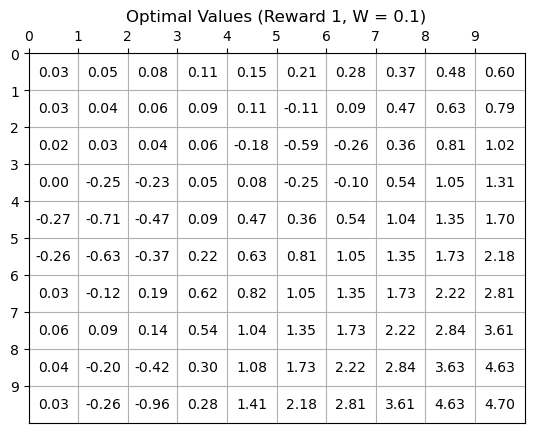

In [84]:
# optimal value figure
value_matrix = np.zeros((grid_size, grid_size))
for i in range(gw.n_states):
    value_matrix[int(i%grid_size)][int(i/grid_size)] = optimal_value_matrix[i]

plot_matrix(value_matrix, title="Optimal Values (Reward 1, W = 0.1)", float_format='{:.2f}')

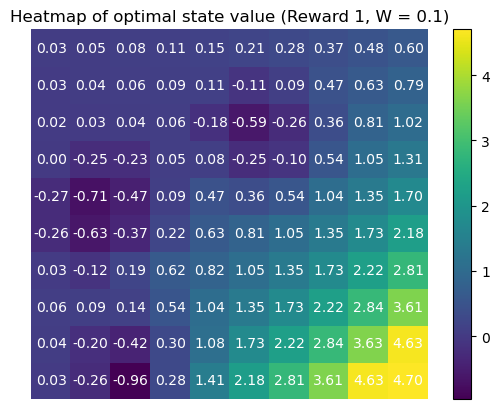

In [86]:
heat_map_plot(value_matrix, title=f'Heatmap of optimal state value (Reward 1, W = 0.1)', float_format='{:.2f}')

## Plot the steps

In [87]:
def snapshot_optimal_value(n_states, n_actions, transition_probabilities, reward,
                  discount, threshold=1e-2):
    """
    Find the optimal value function.

    n_states: Number of states. int.
    n_actions: Number of actions. int.
    transition_probabilities: Function taking (state, action, state) to
        transition probabilities.
    reward: Vector of rewards for each state.
    discount: MDP discount factor. float.
    threshold: Convergence threshold, default 1e-2. float.
    -> Array of values for each state
    """

    v = np.zeros(n_states)

    snapshots = []

    snapshots.append(v.copy())

    delta = np.inf
    steps = 0
    while delta > threshold:
        steps += 1
        delta = 0

        for s in range(n_states):
            v_old = v[s]

            value_arr = np.zeros(n_actions)
            for a in range(n_actions):
                value = 0
                for s_next in range(n_states):
                    value += transition_probabilities[s][a][s_next] * (reward[s_next] + discount * v[s_next])
                value_arr[a] = value

            v[s] = np.max(value_arr)

            delta = max(delta, abs(v[s] - v_old))

        snapshots.append(v.copy())

    print(f"Number of steps: {steps}")
    return v, snapshots, steps

In [88]:
_, snapshots, steps = snapshot_optimal_value(gw.n_states, gw.n_actions, gw.transition_probability,
                  reward_map, gw.discount)

Number of steps: 21


In [103]:
def visualize_value_snapshots(v, snapshots, steps, reward_type):
    snapshot_indices = [int(i) for i in np.linspace(1, steps, 5)]
    selected_snapshots = [snapshots[i] for i in snapshot_indices]

    print("Showing snapshots at iterations:", snapshot_indices)


    for i, (snapshot, idx) in enumerate(zip(selected_snapshots, snapshot_indices)):
        print(f"Iteration {idx}")
        value_matrix = np.zeros((grid_size, grid_size))
        snapshot_grid = snapshot.reshape(grid_size, grid_size)
        #plot
        for i in range(gw.n_states):
            value_matrix[int(i%grid_size)][int(i/grid_size)] = snapshot[i]
        plot_matrix(value_matrix, title=f'Value at Iteration {idx} (Reward {reward_type}, W = 0.1)')
        heat_map_plot(value_matrix, title=f'Heatmap of Value Function at Iteration {idx} (Reward {reward_type}, W = 0.1)')



## Plots and heatmaps

Showing snapshots at iterations: [1, 6, 11, 16, 21]
Iteration 1


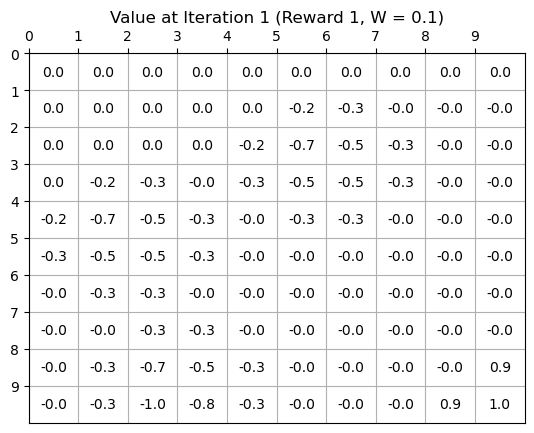

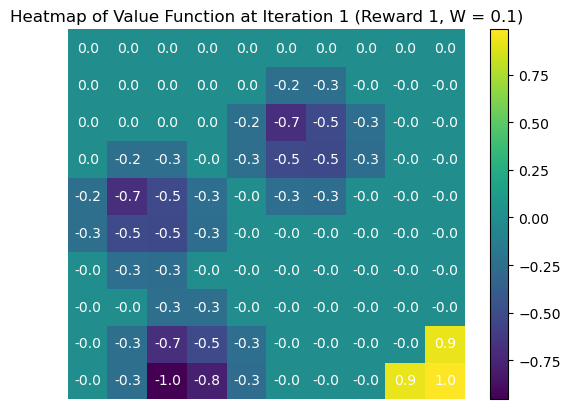

Iteration 6


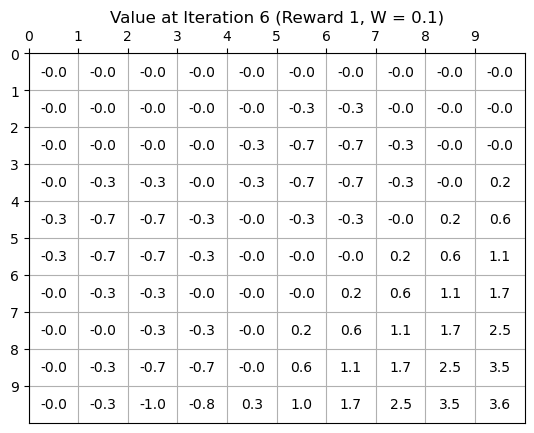

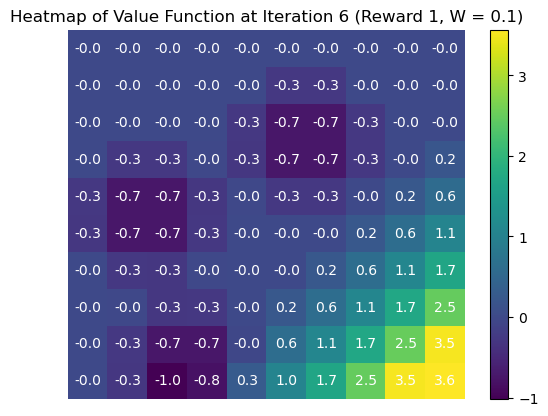

Iteration 11


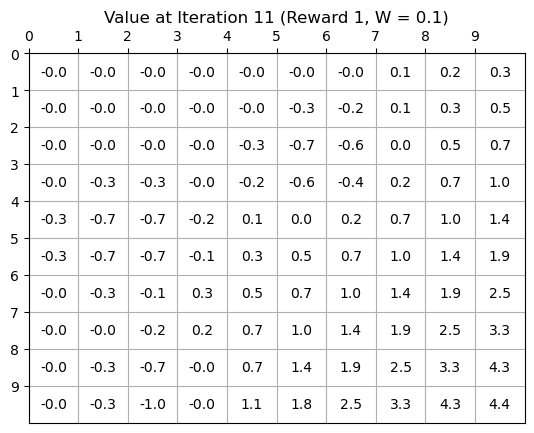

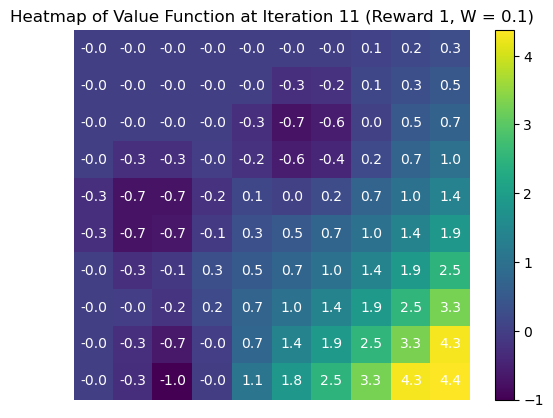

Iteration 16


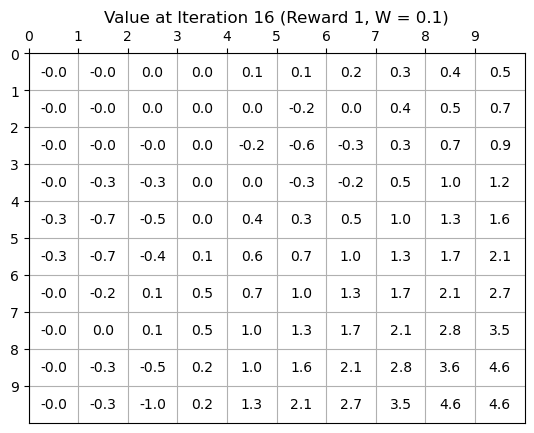

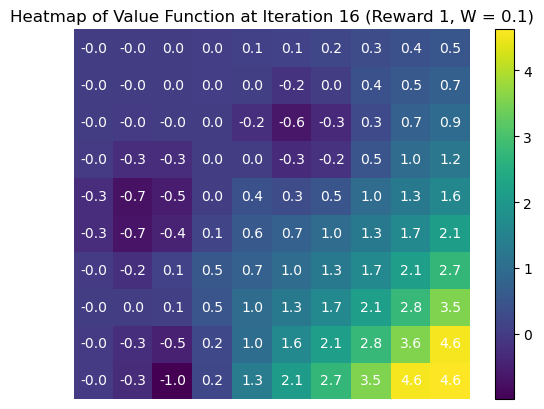

Iteration 21


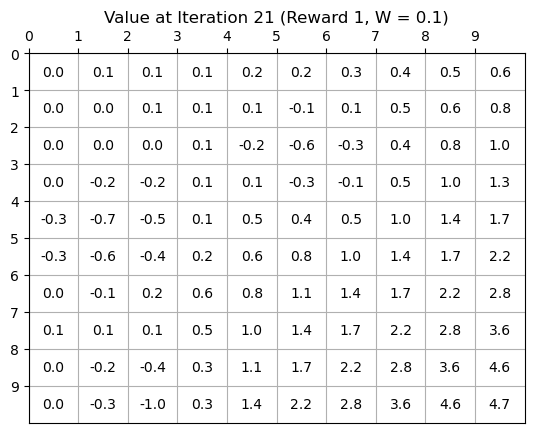

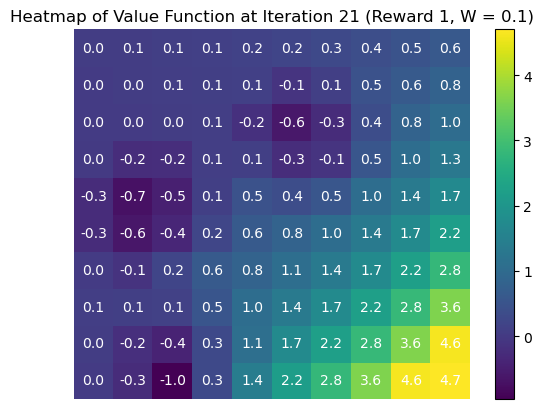

In [104]:
visualize_value_snapshots(optimal_value_matrix, snapshots, steps, reward_type=1)

## Report

The plots are provided above. The number of iterations required for convergence is 21, and we visualised iterations 1, 6, 11, 16 and 21. Below is a comparison and our observations:

At the beginning almost all state values are zero, because they have not yet been updated and they have not been visited. Also, their neighbours have non-zero values. Therefore, they remain far from the negative-rewarding or goal states.

In subsequent iterations the values become smoother (according to the heatmaps). State values near traps decrease, whereas those near the goals increase.

The values of the goal states continue to rise. When w = 0, the optimal value of a goal state should equal $1/(1-\gamma)$.

From iteration~6 onward, the overall heat-map begins to resemble the final solution.

States with high immediate rewards have the greatest state values, while states with a reward of -10 have the lowest values.

State values are updated first around the non-zero-reward states and then propagate outward.


# Question 4

## Report

Near the goal states we observe a region of high values. Areas near the negative-reward states have low values, and because of the stochastic wind the agent can drift into those states even though the optimal policy would normally avoid them.

State 99 and its neighbours have the highest values because of the reward distribution. The farther a state is from any goal state, the lower its value becomes. Since the agent must have more actions to reach the goal. States near sub-optimal regions also have reduced values, and trap rectangular areas with negative rewards, have low values with the same structure as the reward function.

The  pattern of optimal state values approximates the reward function but is smoother and more continuous. The discount factor creates a gradual gradient between states, attenuating abrupt changes present in the raw reward map.

Because of both discounting and the non-zero wind probability, a state that is k steps from the goal has an approximate value of
(1-wind) * discount^k * reward_goal

Interior states (generally) have higher values than edge or corner states because the agent can become stuck against there.

If \(w = 0\), the value of this state would be 1/1-discount. With discount=0.8. this equals 5. Because the wind probability is non-zero, the current value is lower.


# Question 5

In [3]:
def find_policy(n_states, n_actions, transition_probabilities, reward, discount,
                threshold=1e-2, v=None, stochastic=False):
    """
    Find the optimal policy.

    n_states: Number of states. int.
    n_actions: Number of actions. int.
    transition_probabilities: Function taking (state, action, state) to
        transition probabilities.
    reward: Vector of rewards for each state.
    discount: MDP discount factor. float.
    threshold: Convergence threshold, default 1e-2. float.
    v: Value function (if known). Default None.
    stochastic: Whether the policy should be stochastic. Default True.
    -> Action probabilities for each state or action int for each state
        (depending on stochasticity).
    """

    if v is None:
        v = optimal_value(n_states, n_actions, transition_probabilities, reward,
                          discount, threshold)

    def _policy(s):
        new_values = []
        for a in range(n_actions):
            new_values.append(np.dot(transition_probabilities[s][a],
                                        (reward + discount * v)))
        return np.argmax(new_values)

    policy = np.array([_policy(s) for s in range(n_states)])
    return policy

def plot_arrow(action_matrix):

    fig, ax = plt.subplots()
    num_rows = len(action_matrix)
    min_val, max_val = 0, num_rows

    for i in range(num_rows):
        for j in range(num_rows):
            c = action_matrix[i][j]
            arrow = ''
            if(c == 0):
                arrow = u'↓'
            elif(c == 1):
                arrow = u'→'
            elif(c == 2):
                arrow = u'↑'
            else:
                arrow = u'←'

            ax.text(j + 0.5, i + 0.5, arrow, va='center', ha='center')

    ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val, min_val)
    ax.set_xticks(np.arange(max_val))
    ax.set_yticks(np.arange(max_val))
    ax.xaxis.tick_top()
    ax.grid()

Number of states is 21


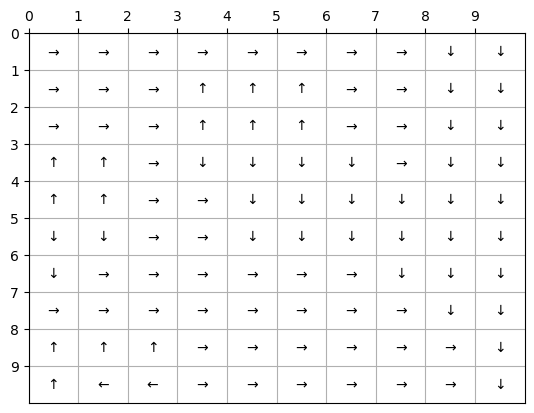

In [128]:
optimal_policy = find_policy(gw.n_states, gw.n_actions, gw.transition_probability, reward_map, gw.discount, stochastic=False)

# Generating the matrix containing the optimal actions

action_matrix = np.zeros((grid_size, grid_size))
for i in range(gw.n_states):
    action_matrix[int(i%grid_size)][int(i/grid_size)] = optimal_policy[i]


# Plotting
plot_arrow(action_matrix)
plt.show()

In [129]:
def plot_arrow_with_rewards(action_matrix, reward_matrix):
    fig, ax = plt.subplots()
    num_rows = len(action_matrix)
    min_val, max_val = 0, num_rows

    # Plot arrows
    for i in range(num_rows):
        for j in range(num_rows):
            c = action_matrix[i][j]
            arrow = ''
            if c == 0:
                arrow = u'↓'
            elif c == 1:
                arrow = u'→'
            elif c == 2:
                arrow = u'↑'
            else:
                arrow = u'←'

            ax.text(j + 0.5, i + 0.5, arrow, va='center', ha='center')

    for i in range(num_rows):
        for j in range(num_rows):
            if reward_matrix[i][j] != 0:
                rect = plt.Rectangle((j, i), 1, 1, 
                                   fill=False, 
                                   edgecolor='red' if reward_matrix[i][j] < 0 else 'green',
                                   linewidth=2)
                ax.add_patch(rect)
                
                ax.text(j + 0.5, i + 0.5, 
                       f'\n{reward_matrix[i][j]}', 
                       va='center', 
                       ha='center',
                       color='red' if reward_matrix[i][j] < 0 else 'green')

    ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val, min_val)
    ax.set_xticks(np.arange(max_val))
    ax.set_yticks(np.arange(max_val))
    ax.xaxis.tick_top()
    ax.grid()
    plt.title('Policy with Rewards')
    plt.show()

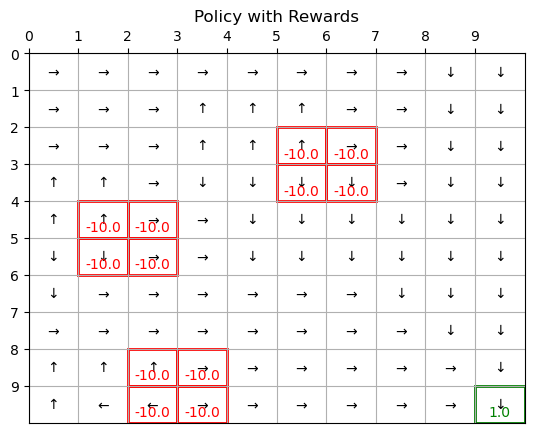

In [130]:
plot_arrow_with_rewards(action_matrix, reward_matrix_1.reshape(10, 10))

## Report

According to the arrow plot, at every state the agent wants to move to the goal while avoiding the trap regions. Near states with negative rewards, the policy makes the agent away from those areas.

At each state, the chosen action points toward a neighbour with a higher value than the current one. The policy therefore has a local search for the steepest ascent in value. Intuitively, this behaviour shows the the agent follows the shortest path to the goal.

All arrows converge on the goal state, and in the trap zone they make the agent escape. Consequently, most actions guide the agent toward high-reward states.

Because of the non-zero wind, arrows adjacent to the trap sometimes shows a longer path but safer. For example, the arrow at (2,5).

Overall, the observed policy is consistent with the Bellman optimality equation: rewards depend on the next state, and the greedy action at each step maximises the expected discounted return.


# Question 6

In [ ]:
# For modifying the environment, we need to call reward_type==2 when running experiments.

In [105]:
reward_map_2 = gw.reward(reward_type=2)
optimal_value_matrix_2 = optimal_value(gw.n_states, gw.n_actions, gw.transition_probability,
                  reward_map_2, gw.discount)

Number of states is 31


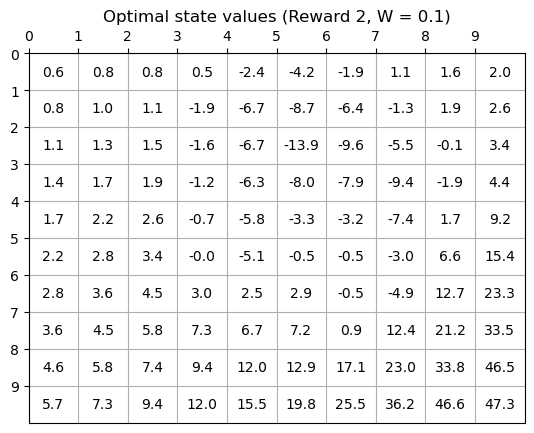

In [106]:
# optimal value figure for reward 2

value_matrix_2 = np.zeros((grid_size, grid_size))
for i in range(gw.n_states):
    value_matrix_2[int(i%grid_size)][int(i/grid_size)] = optimal_value_matrix_2[i]

plot_matrix(value_matrix_2, title='Optimal state values (Reward 2, W = 0.1)')

# Question 7

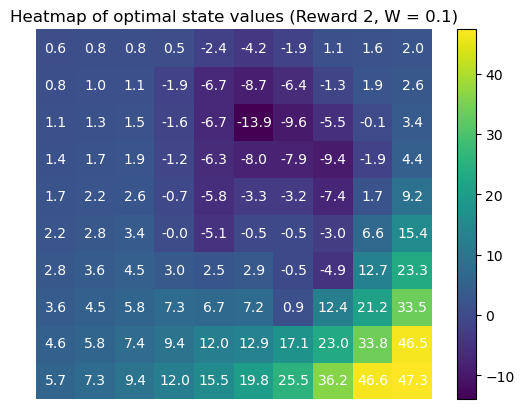

In [107]:
heat_map_plot(value_matrix_2, title=f'Heatmap of optimal state values (Reward 2, W = 0.1)')

## Report

The number of steps to convere in this case was 31. Because of the structure of the reward, getting out of the trapped states is harder.

The lowest values is at state 2, 5 (-13.9), and in the reward function tha state is a trap that escaping from is hard.

Neighbors to the states with negative results are also negative since the non-zero wind can make the agents go there and then be trapped and lowering their expected returns.

Edge and corners have lower positive values since the agent can be stuck there while taking some actions. This increases the expected path length to the goal.

The heat map plot shows a smooth transition of values and a continuous gradient from high-reward states toward the low-reward areas. The value function is smoother than the reward map due to the effect of discounting and wind.

The goal state has the largest value which is 47.3 and if wind was 0, it would be 1/1-0.2 * 10 (50). The neighbors to the goal state changes are smooth, which agein is a gradient that rises toward the goal state.

# Question 8

In [108]:
_, snapshots_2, steps_2 = snapshot_optimal_value(gw.n_states, gw.n_actions, gw.transition_probability,
                  reward_map_2, gw.discount)

Number of steps: 31


Showing snapshots at iterations: [1, 8, 16, 23, 31]
Iteration 1


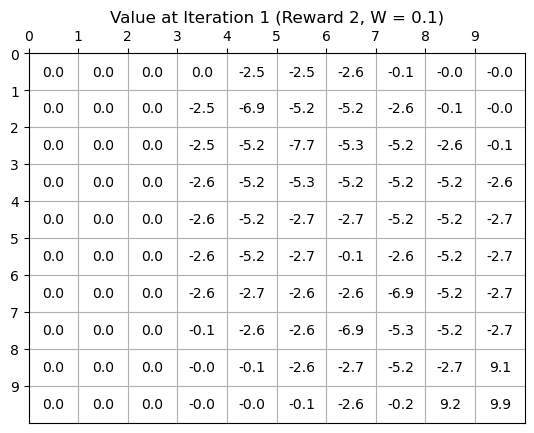

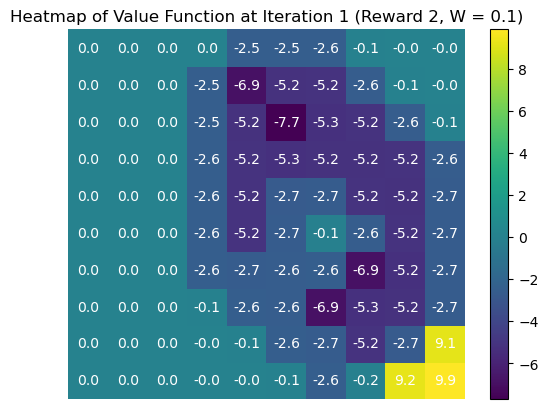

Iteration 8


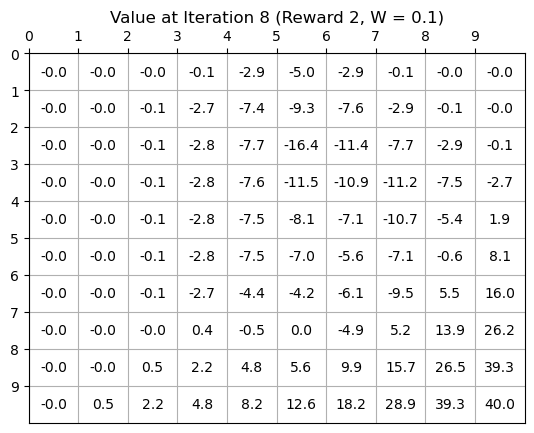

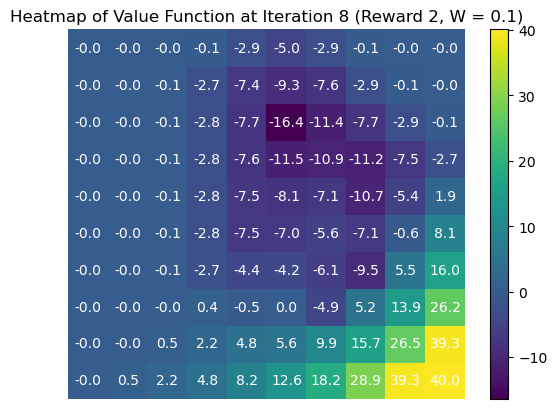

Iteration 16


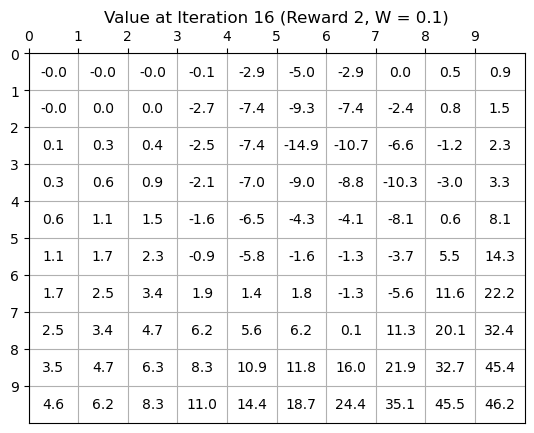

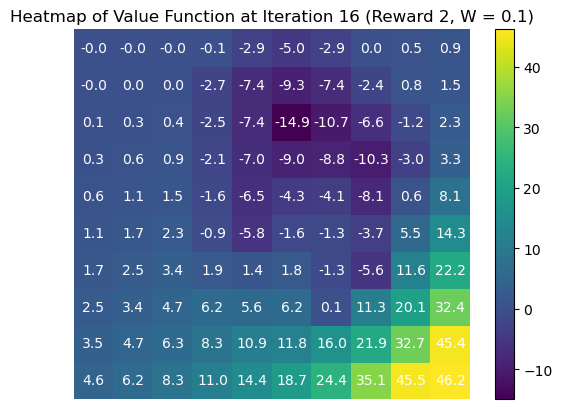

Iteration 23


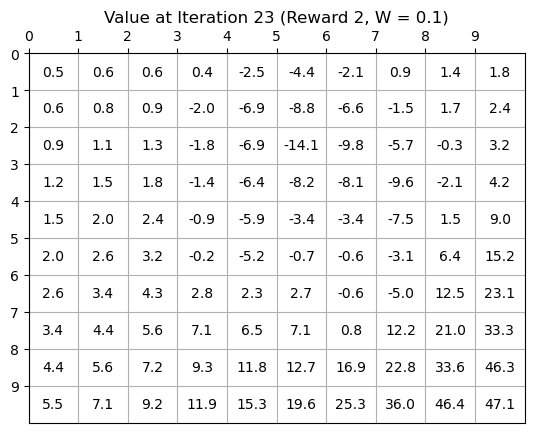

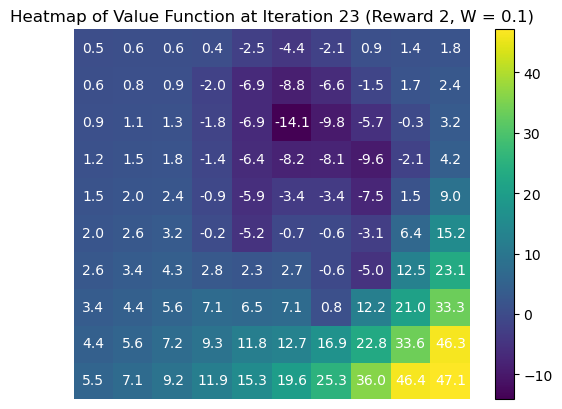

Iteration 31


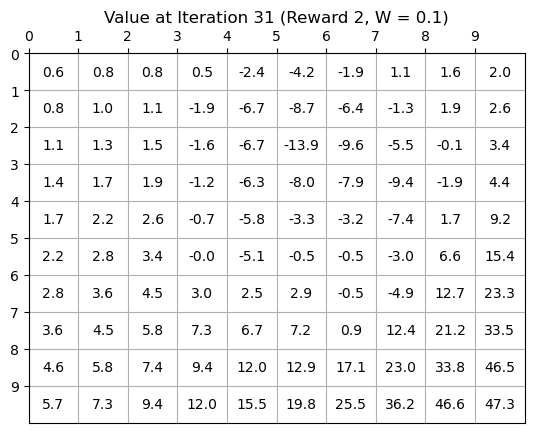

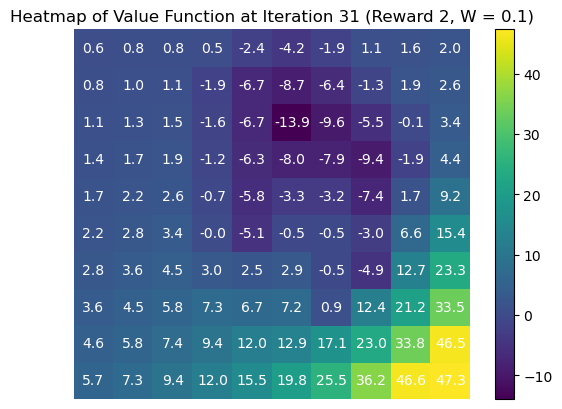

In [110]:
visualize_value_snapshots(optimal_value_matrix_2, snapshots_2, steps_2, reward_type=2)

Number of states is 31


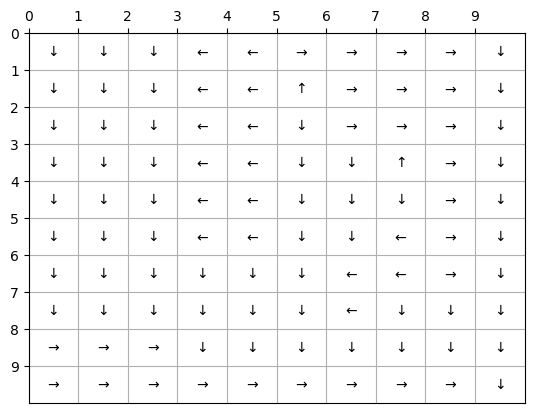

In [115]:
optimal_policy_2 = find_policy(gw.n_states, gw.n_actions, gw.transition_probability, reward_map_2, gw.discount, stochastic=False)

# Generating the matrix containing the optimal actions

action_matrix_2 = np.zeros((grid_size, grid_size))
for i in range(gw.n_states):
    action_matrix_2[int(i%grid_size)][int(i/grid_size)] = optimal_policy_2[i]


# Plotting
plot_arrow(action_matrix_2)
plt.show()

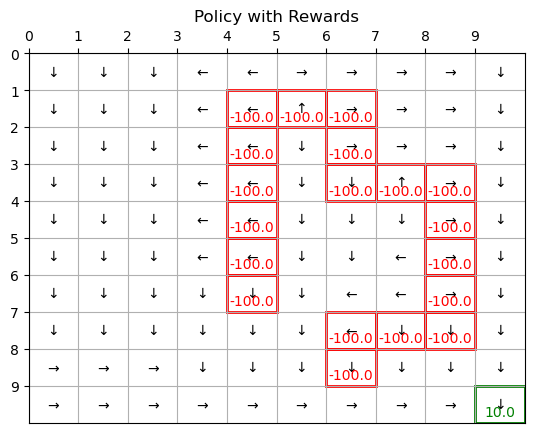

In [122]:
plot_arrow_with_rewards(action_matrix_2, reward_map_2.reshape(10, 10).T)

## Report

we can see the policy leads the agent escape from traps' area.

The plot is again what we expected, the intuition was explained in the section related to the rewad 1. The actions points to the goal state and makes the agent escape from the traps. Also, we see sometimes agent makes its path longer, like in 1, 5 to make sure even with wind it cannot be stuck. 

# Question 9

In [131]:
grid_size = 10 #number of states = 100
wind = 0.6
discount = 0.8

# Make the gridworld and associated data.
gw = Gridworld(grid_size, wind, discount)

## Reward 1

Number of states is 16


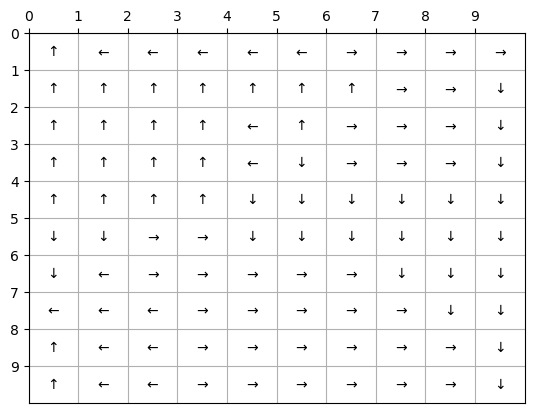

In [132]:
reward_map_1 = gw.reward(reward_type=1)
reward_map_2 = gw.reward(reward_type=2)

optimal_policy_1 = find_policy(gw.n_states, gw.n_actions, gw.transition_probability, reward_map_1, gw.discount, stochastic=False)

# Generating the matrix containing the optimal actions

action_matrix_1 = np.zeros((grid_size, grid_size))
for i in range(gw.n_states):
    action_matrix_1[int(i%grid_size)][int(i/grid_size)] = optimal_policy_1[i]


# Plotting
plot_arrow(action_matrix_1)
plt.show()

Number of states is 16


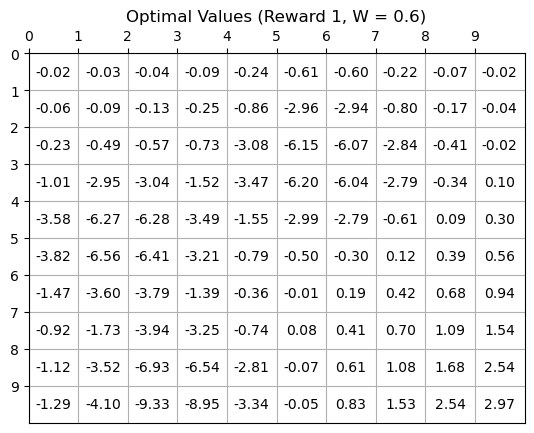

In [141]:
optimal_value_matrix = optimal_value(gw.n_states, gw.n_actions, gw.transition_probability,
                  reward_map_1, gw.discount)
value_matrix = np.zeros((grid_size, grid_size))
for i in range(gw.n_states):
    value_matrix[int(i%grid_size)][int(i/grid_size)] = optimal_value_matrix[i]

plot_matrix(value_matrix, title="Optimal Values (Reward 1, W = 0.6)", float_format='{:.2f}')

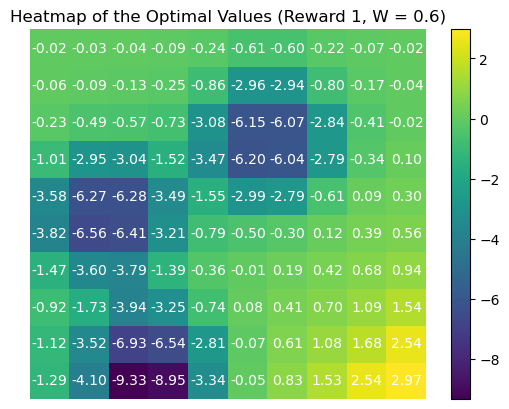

In [142]:
heat_map_plot(value_matrix, title="Heatmap of the Optimal Values (Reward 1, W = 0.6)", float_format='{:.2f}')

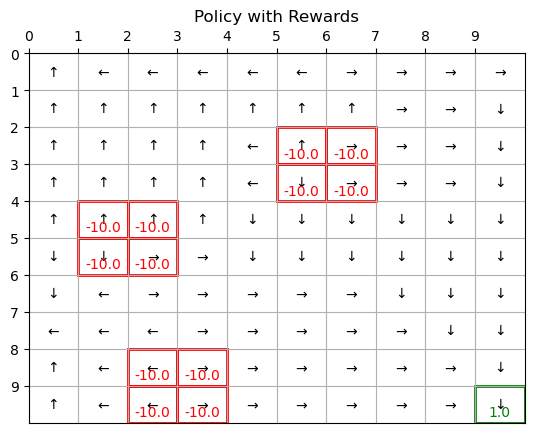

In [133]:
plot_arrow_with_rewards(action_matrix_1, reward_map_1.reshape(10, 10).T)

## Reward 2

Number of states is 22


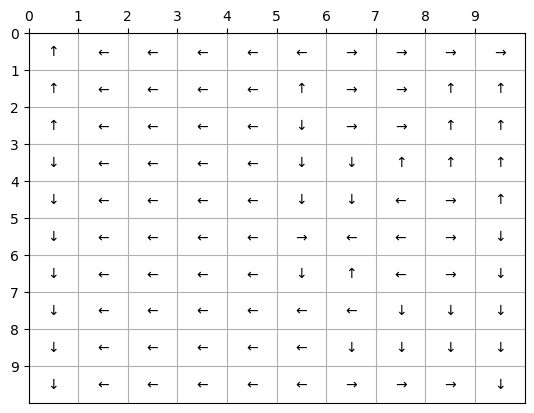

In [136]:
optimal_policy_2 = find_policy(gw.n_states, gw.n_actions, gw.transition_probability, reward_map_2, gw.discount, stochastic=False)

# Generating the matrix containing the optimal actions

action_matrix_2 = np.zeros((grid_size, grid_size))
for i in range(gw.n_states):
    action_matrix_2[int(i%grid_size)][int(i/grid_size)] = optimal_policy_2[i]


# Plotting
plot_arrow(action_matrix_2)
plt.show()

Number of states is 22


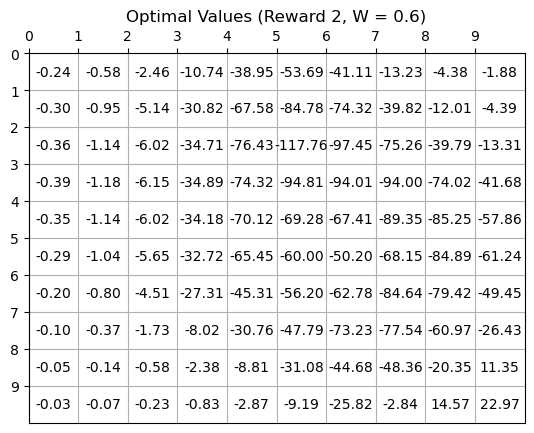

In [145]:
optimal_value_matrix = optimal_value(gw.n_states, gw.n_actions, gw.transition_probability,
                  reward_map_2, gw.discount)
value_matrix = np.zeros((grid_size, grid_size))
for i in range(gw.n_states):
    value_matrix[int(i%grid_size)][int(i/grid_size)] = optimal_value_matrix[i]

plot_matrix(value_matrix, title="Optimal Values (Reward 2, W = 0.6)", float_format='{:.2f}')

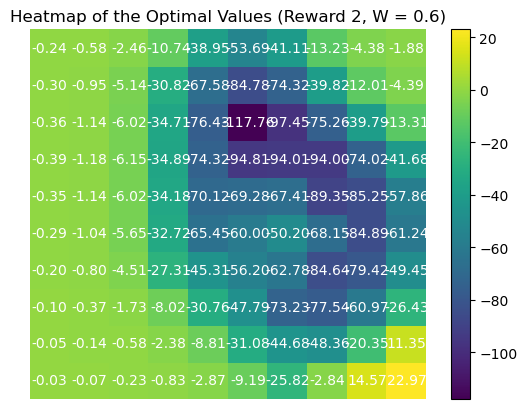

In [146]:
heat_map_plot(value_matrix, title="Heatmap of the Optimal Values (Reward 2, W = 0.6)", float_format='{:.2f}')

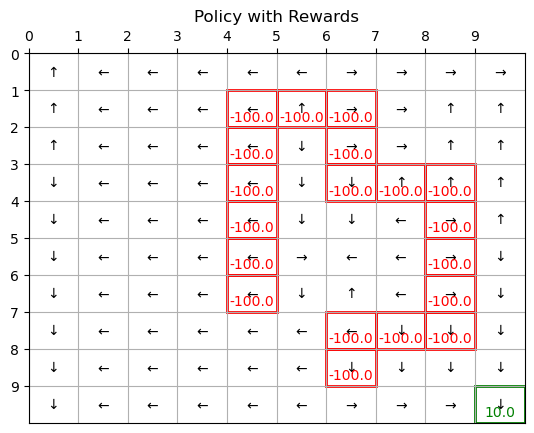

In [137]:
plot_arrow_with_rewards(action_matrix_2, reward_map_2.reshape(10, 10).T)

## Report

The agent has a higher probability of hitting the traps because of the higher wind value.

Te wind makes the agent explore and it may help to acoid local optimum, so, the higher wind makes more exploration. 

The wind makes the agent explore, and it may help to avoid local optima, so the higher wind leads to more exploration.

Higher wind causes the agent to move more in the wind direction rather than the intended action. 

We see that the convergence steps are fewer for both rewards; however, the overall values are also lower.

We see that higher rewards are more distinct in the heat-map compared with the lower wind. This could be because the higher wind allows for better approximation of the reward functions.

The optimal policy results in some actions that make the agent stuck, such as in the corners, if the agent does not make any random move due to the wind.

Paths to the goal in the policy plot are longer and less direct. Many arrows steer the agent away from traps at the cost of a longer path length to the goal because of the higher wind. For example, look at the red area in the plots, such as (6, 4), where the arrow shows the agent moving to the left.

With higher wind, the environment is unstable. 

Wind = 0.1 is better because of the higher values and the lower possibility of getting stuck.